# Problem Statement

An online question and answer platform has hired you as a data scientist to identify the best question authors on the platform. This identification will bring more insight into increasing the user engagement. Given the tag of the question, number of views received, number of answers, username and reputation of the question author, the problem requires you to predict the upvote count that the question will receive.

You can download the dataset from [here](https://datahack.analyticsvidhya.com/contest/enigma-codefest-machine-learning-1/#ProblemStatement).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/upvotes-prediction/train_NIR5Yl1.csv
/kaggle/input/upvotes-prediction/test_8i3B3FC.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from category_encoders import TargetEncoder

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

# Importing the data and Understanding the features

In [4]:
train_df = pd.read_csv('/kaggle/input/upvotes-prediction/train_NIR5Yl1.csv')
test_df = pd.read_csv('/kaggle/input/upvotes-prediction/test_8i3B3FC.csv')

In [5]:
cat_train = train_df.copy()
cat_test = test_df.copy()
test_ids = test_df['ID'].copy()

In [6]:
train_df.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


**ID**         -> Question ID

**Tag**        -> Anonymised tags representing question category

**Reputation** -> Reputation score of question author

**Answers**    -> Number of times question has been answered

**Username**   -> Anonymised user id of question author

**Views**      -> Number of times question has been viewed

**Upvotes**(Target) -> Number of upvotes for the question

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          330045 non-null  int64  
 1   Tag         330045 non-null  object 
 2   Reputation  330045 non-null  float64
 3   Answers     330045 non-null  float64
 4   Username    330045 non-null  int64  
 5   Views       330045 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [8]:
train_df.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


# Filling Missing Values

In [9]:
train_df.isna().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
Upvotes       0
dtype: int64

In [10]:
test_df.isna().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
dtype: int64

Since there are no missing values, there is no need to impute any values.

# Exploratory Data Analysis

In [11]:
eda_df = train_df.copy()

It's easier to visualize data if the data is normalized as the analysis is mostly likely to be bivariate.

In [12]:
scaler_eda = MinMaxScaler()
eda_df[['Reputation','Answers','Views']]= scaler_eda.fit_transform(eda_df[['Reputation','Answers','Views']])

<AxesSubplot:xlabel='variable', ylabel='value'>

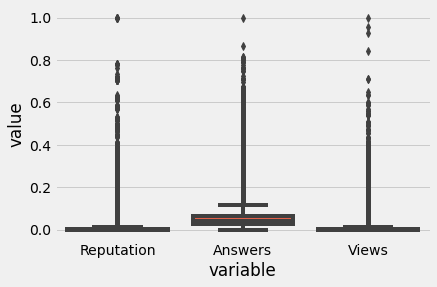

In [13]:
melt = pd.melt(eda_df[['Reputation','Answers','Views']])
sns.boxplot(data=melt, x='variable',y='value')

As the boxplot indicates, this data has a lot of outliers. These outliers should be handled so that they do not affect the model.

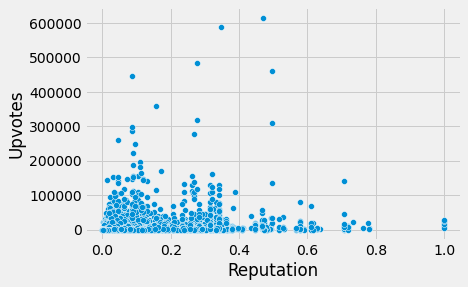

In [14]:
sns.scatterplot(data=eda_df, x='Reputation',y='Upvotes');

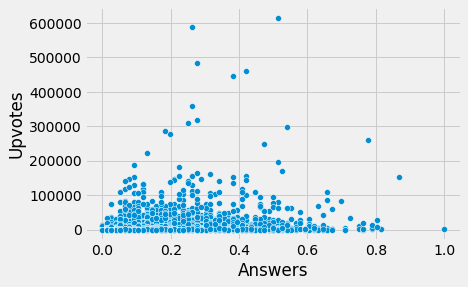

In [15]:
sns.scatterplot(data=eda_df, x='Answers',y='Upvotes');

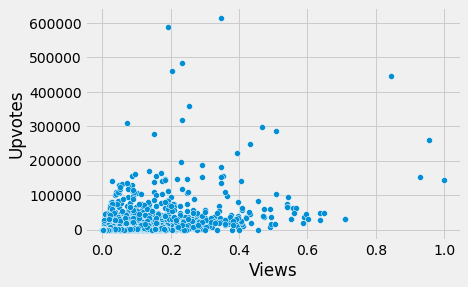

In [16]:
sns.scatterplot(data=eda_df, x='Views',y='Upvotes');

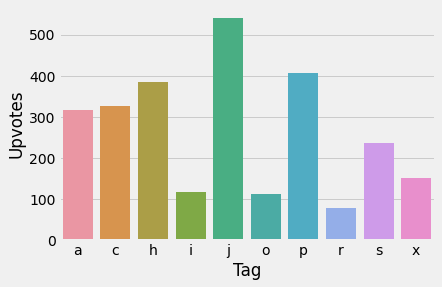

In [17]:
group = eda_df.groupby(by='Tag').mean()
sns.barplot(data=group, x=group.index,y='Upvotes');

The above graph shows that on an average, tags with j tag tend to get more upvotes when compared to any other tags.

# Encoding Categorical Variables

In [18]:
train_df.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [19]:
numeric_col = ['Reputation','Answers','Views']
categoric_col = ['Tag','Username']
encoder_tag = TargetEncoder().fit(train_df['Tag'],train_df['Upvotes'])
encoder_ID = TargetEncoder().fit(train_df['Username'],train_df['Upvotes'])

def encode_and_normalize(dataframe):
    dataframe['Tag'] = encoder_tag.transform(train_df['Tag'])
    dataframe['Username'] = encoder_ID.transform(train_df['Username'])
    dataframe[numeric_col] = MinMaxScaler().fit_transform(dataframe[numeric_col])
    dataframe[categoric_col] = MinMaxScaler().fit_transform(dataframe[categoric_col])
    return dataframe

/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [20]:
encode_and_normalize(train_df).head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,0.514662,0.003782,0.026316,0.885540,0.001500,42.0
1,327662,0.514662,0.024986,0.157895,0.123940,0.010666,1175.0
2,468453,0.538744,0.001303,0.052632,0.319663,0.001540,60.0
3,96996,0.514662,0.000253,0.039474,0.960481,0.005172,9.0
4,131465,0.538744,0.004097,0.052632,0.638581,0.002672,83.0


# Splitting the data into train data and test data

In [21]:
input_cols = list(numeric_col)
input_cols.extend(categoric_col)
target_col = 'Upvotes'
input_cols

['Reputation', 'Answers', 'Views', 'Tag', 'Username']

In [22]:
train_df = encode_and_normalize(train_df)

In [23]:
train_x, test_x, train_y, test_y = train_test_split(train_df[input_cols],train_df[target_col],random_state=42, shuffle = True, test_size = 0.4)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((198027, 5), (132018, 5), (198027,), (132018,))

# Building Machine Learning Models

### 1. KNeighbors Regressor Model

In [24]:
knn = KNeighborsRegressor(n_neighbors=3, weights='distance', n_jobs=-1)
knn.fit(train_x,train_y)
print(mean_squared_error(train_y, knn.predict(train_x), squared=False),
                                mean_squared_error(test_y, knn.predict(test_x), squared=False)) #1878

43.40285179156127 2367.827760023802


### 2. Decision Tree Model

In [25]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(train_x,train_y)
print(mean_squared_error(train_y, dt.predict(train_x), squared=False),
                            mean_squared_error(test_y, dt.predict(test_x), squared=False)) #1705

43.40285171238028 1690.8789623519056


### 3. Random Forest Regressor

In [26]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(train_x,train_y)
print(mean_squared_error(train_y, rf.predict(train_x), squared=False), 
                    mean_squared_error(test_y, rf.predict(test_x), squared=False)) #1165

585.1874192552758 1396.3815699737793


### 4. XGBoost Regressor Model

In [27]:
xgb = XGBRegressor(random_state=42)
xgb.fit(train_x,train_y)
print(mean_squared_error(train_y, xgb.predict(train_x), squared=False), 
                    mean_squared_error(test_y, xgb.predict(test_x), squared=False)) #937

277.586301401145 1378.891428760903


### Voting

In [28]:
vr = VotingRegressor(
                estimators = [('dt',dt),('rf',rf), ('xgb',xgb)],
                n_jobs=-1)
vr.fit(train_x,train_y)
print(mean_squared_error(train_y, vr.predict(train_x), squared=False), 
                    mean_squared_error(test_y, vr.predict(test_x), squared=False)) #1326

240.67439214232337 1430.9436450112507


# Predictions

In [29]:
test_df = encode_and_normalize(test_df)

In [30]:
preds = vr.predict(test_df[input_cols])

In [31]:
output = pd.DataFrame({'ID':test_ids, 'Upvotes':preds})
output.to_csv('submission.csv',index=False)

Best Model -> XGBRegressor